In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from pathlib import Path

In [3]:
root_p = Path('/home/neuromod/ASD_project_clean')
pheno_validation_p = root_p / 'Data/ABIDE_2_Pheno_PSM_matched_ados.tsv'
pheno_boot_p = root_p / 'Data/ABIDE_1_Pheno_PSM_matched_ados.tsv'
model_1_valid_p = root_p / 'Results/Validation/validation_net_split_1_model_1_combined_p_values.tsv'
model_2_valid_p = root_p / 'Results/Validation/validation_net_split_1_model_2_combined_p_values.tsv'
p0_boot_p = root_p / 'Results/Discovery/split_net_1_p0.tsv'
p1_boot_p = root_p / 'Results/Discovery/split_net_1_p1.tsv'
boot_id_p = root_p / 'Results/Discovery/boot_subject_ids.tsv'

fig_p = root_p / 'Figures/fig4'
fig_p.mkdir(parents=True, exist_ok=True) 

In [4]:
pheno_valid = pd.read_csv(pheno_validation_p, sep='\t')
pheno_boot = pd.read_csv(pheno_boot_p, sep='\t')
model1_valid = pd.read_csv(model_1_valid_p, sep='\t')
model2_valid = pd.read_csv(model_2_valid_p, sep='\t')
p0_boot = pd.read_csv(p0_boot_p, sep='\t')
p1_boot = pd.read_csv(p1_boot_p, sep='\t')
boot_id = pd.read_csv(boot_id_p, sep='\t', header=None)

In [5]:
classes_validation = (pheno_valid.DX_GROUP=='Autism').values.astype(int)
classes_boot = (pheno_boot.DX_GROUP=='Autism').values.astype(int)

In [6]:
base_rate = 1/90

In [7]:
# Compute for known Genes
# 16pDEL11.2
cnv16p_del = [0.0001, 0.22]
cnv16p_dup = [0.0003, 0.26]
cnv_22q_del = [1/4000, 0.3]

snp_rs910805 = [0.76, 0.01278454541]
snp_rs10099100 = [0.6872, 0.01263397433]
snp_rs201910565 = [0.689, 0.01254695107]
snp_rs71190156 = [0.481, 0.01255934664]
snp_rs111931861 = [0.966, 0.0123910774] # 0.0143910774]

gene_FMR1 = [1.4/10000, 0.4339622642] # Fragile X
gene_TSC2 = [1/25000, 0.4965277778] # Tuberous sclerosis complex
gene_DHCR7 = [1/60000, 0.6774193548] # Smith-Lemli-Opitz Syndrome
gene_UBE3A = [1/20000, 0.6585365854] # Angelman syndrome

### Validated HCS

In [8]:
base_rate = 1/90
thr = 0.2
l_or = list()
l_prevalence = list()
for i in range(100):
    ind_idx = (boot_id.iloc[:, i]-1).values
    boot_sample_classes = classes_boot[ind_idx]
    p1 = p1_boot.iloc[:, i].values
    p0 = p0_boot.iloc[:, i].values
    predict_asd = ((p1>thr) & (p0<=thr)).astype(int)
    p = sum(boot_sample_classes==1)
    n = sum(boot_sample_classes==0)
    tp = sum((boot_sample_classes==1) & (predict_asd==1))
    fp = sum((boot_sample_classes==0) & (predict_asd==1))
    fn = sum((boot_sample_classes==1) & (predict_asd==0))
    tn = sum((boot_sample_classes==0) & (predict_asd==0))

    sens = tp / p
    spec = tn / n
    # Estimate population parameters off the baserate
    pop_p = base_rate
    pop_n = (1-base_rate)
    pop_tp = pop_p*sens
    pop_tn = pop_n*spec
    pop_fp = pop_n-pop_tn
    pop_fn = pop_p-pop_tp
    pop_ppv = pop_tp / (pop_tp + pop_fp)
    pop_or = pop_ppv / base_rate
    pop_labeled = (pop_tp + pop_fp) / 1.0
    pop_jacc = pop_tp / ((base_rate + pop_labeled) - pop_tp)
    #l_prevalence.append(np.log10(pop_labeled))
    l_or.append(pop_ppv)
    l_prevalence.append(pop_labeled)
    #l_prevalence.append(sens)
data = pd.DataFrame({'Odds': l_or, 'Prevalence':l_prevalence})

/tmp/ipykernel_1286228/1501850102.py:27: RuntimeWarning: invalid value encountered in scalar divide
  pop_ppv = pop_tp / (pop_tp + pop_fp)


In [9]:
base_rate = 1/90

In [10]:
thr = 0.2
# Validated model (model 2)
predict_asd_validation = ((model2_valid.iloc[:, 0].values>thr) & (model2_valid.iloc[:,1].values<=thr)).astype(int)
classes_validation

p = sum(classes_validation==1)
n = sum(classes_validation==0)
tp = sum((classes_validation==1) & (predict_asd_validation==1))
fp = sum((classes_validation==0) & (predict_asd_validation==1))
fn = sum((classes_validation==1) & (predict_asd_validation==0))
tn = sum((classes_validation==0) & (predict_asd_validation==0))

sens = tp / p
spec = tn / n
ppv = tp / (tp + fp)
# Estimate population parameters off the baserate
pop_p = base_rate
pop_n = (1-base_rate)
pop_tp = pop_p*sens
pop_tn = pop_n*spec
pop_fp = pop_n-pop_tn
pop_fn = pop_p-pop_tp
pop_ppv = pop_tp / (pop_tp + pop_fp)
pop_or = pop_ppv / base_rate
pop_labeled = (pop_tp + pop_fp) / 1.0
pop_jacc = pop_tp / ((base_rate + pop_labeled) - pop_tp)
validated_hcp = [pop_labeled, pop_ppv]
print(f"Ensemble 2 sensitivity = {sens}, specificity = {spec}, population PPV = {pop_ppv}")

Ensemble 2 sensitivity = 0.07075471698113207, specificity = 0.9575471698113207, PPV = 0.625, population PPV = 0.018382352941176464


In [11]:
thr = 0.2
# Validated model (model 1)
predict_asd_validation = ((model1_valid.iloc[:, 0].values>thr) & (model1_valid.iloc[:,1].values<=thr)).astype(int)
classes_validation

p = sum(classes_validation==1)
n = sum(classes_validation==0)
tp = sum((classes_validation==1) & (predict_asd_validation==1))
fp = sum((classes_validation==0) & (predict_asd_validation==1))
fn = sum((classes_validation==1) & (predict_asd_validation==0))
tn = sum((classes_validation==0) & (predict_asd_validation==0))

sens = tp / p
spec = tn / n
ppv = tp / (tp + fp)
# Estimate population parameters off the baserate
pop_p = base_rate
pop_n = (1-base_rate)
pop_tp = pop_p*sens
pop_tn = pop_n*spec
pop_fp = pop_n-pop_tn
pop_fn = pop_p-pop_tp
pop_ppv = pop_tp / (pop_tp + pop_fp)
pop_or = pop_ppv / base_rate
pop_labeled = (pop_tp + pop_fp) / 1.0
pop_jacc = pop_tp / ((base_rate + pop_labeled) - pop_tp)
validated_hcp = [pop_labeled, pop_ppv]
print(f"Ensemble 1 sensitivity = {sens}, specificity = {spec}, population PPV = {pop_ppv}")
print(f"TP = {pop_tp}, FP = {pop_fp}")

Ensemble 1 sensitivity = 0.04245283018867924, specificity = 0.9952830188679245, PPV = 0.9, population PPV = 0.09183673469387575
TP = 0.0004716981132075472, FP = 0.004664570230608067


In [12]:
# Compute this for Abraham
sens = 0.61
spec = 0.723
# Estimate population parameters off the baserate
pop_p = base_rate
pop_n = (1-base_rate)
pop_tp = pop_p*sens
pop_tn = pop_n*spec
pop_fp = pop_n-pop_tn
pop_fn = pop_p-pop_tp
pop_ppv = pop_tp / (pop_tp + pop_fp)
pop_or = pop_ppv / base_rate
pop_labeled = (pop_tp + pop_fp) / 1.0
pop_jacc = pop_tp / ((base_rate + pop_labeled) - pop_tp)
abraham = [pop_labeled, pop_ppv]

In [13]:
# Compute this for Craddock
sens = 0.74
spec = 0.63
# Estimate population parameters off the baserate
pop_p = base_rate
pop_n = (1-base_rate)
pop_tp = pop_p*sens
pop_tn = pop_n*spec
pop_fp = pop_n-pop_tn
pop_fn = pop_p-pop_tp
pop_ppv = pop_tp / (pop_tp + pop_fp)
pop_or = pop_ppv / base_rate
pop_labeled = (pop_tp + pop_fp)
pop_jacc = pop_tp / ((base_rate + pop_labeled) - pop_tp)
craddock = [pop_labeled, pop_ppv]

In [14]:
# Compute this for Traut
tpr = 0.254
fpr = 0.03

sens = tpr
spec = 1-fpr
# Estimate population parameters off the baserate
pop_p = base_rate
pop_n = (1-base_rate)
pop_tp = pop_p*sens
pop_tn = pop_n*spec
pop_fp = pop_n-pop_tn
pop_fn = pop_p-pop_tp
pop_ppv = pop_tp / (pop_tp + pop_fp)
pop_or = pop_ppv / base_rate
pop_labeled = (pop_tp + pop_fp)
pop_jacc = pop_tp / ((base_rate + pop_labeled) - pop_tp)
traut = [pop_labeled, pop_ppv]

In [15]:
def mm2in(mm):
    return mm/25.4

In [16]:
def jacc(x, base_rate=1/90):
    return (x[0]*x[1]) / ((base_rate + x[0]) - x[0]*x[1])

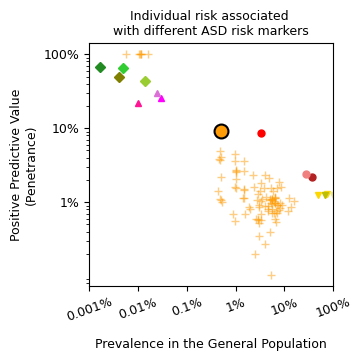

In [17]:
dpi=300
scale_factor = 1
height = 80 * scale_factor
width = 80 * scale_factor

fs = 9

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=False)

ax = f.add_subplot(111)
ax.plot(validated_hcp[0], validated_hcp[1], marker='o', markersize=10, markerfacecolor='#FE9D08',
             markeredgewidth=1.5, markeredgecolor='black', linestyle = 'None', label='High Risk Signature (replicated)')
ax.scatter(data.Prevalence, data.Odds, c='#FE9D08', alpha=0.5, s=30, linewidth=1, marker="+", linestyle = 'None', label='High Risk Signature (bootstrap)')
# fMRI
ax.plot(craddock[0], craddock[1], marker='o', markersize=5, color="firebrick", linestyle = 'None', label='Heinsfeld (2018)')
ax.plot(abraham[0], abraham[1], marker='o', markersize=5, color="lightcoral", linestyle = 'None', label='Abraham (2017)')
ax.plot(traut[0], traut[1], marker='o', markersize=5, color="red", linestyle = 'None', label='Traut (2022)')
# CNV
ax.plot(cnv16p_del[0], cnv16p_del[1], marker='^', markersize=5, color="deeppink", linestyle = 'None', label='CNV16p11.2 DEL')
ax.plot(cnv16p_dup[0], cnv16p_dup[1], marker='^', markersize=5, color="magenta", linestyle = 'None', label='CNV16p11.2 DUP')
ax.plot(cnv_22q_del[0], cnv_22q_del[1], marker='^', markersize=5, color="orchid", linestyle = 'None', label='CNV22q11.2 DEL')
# SNP
ax.plot(snp_rs910805[0], snp_rs910805[1], marker='v', markersize=5, color="gold", linestyle = 'None', label='SNP rs910805')
ax.plot(snp_rs10099100[0], snp_rs10099100[1], marker='v', markersize=5, color="khaki", linestyle = 'None', label='SNP rs10099100')
ax.plot(snp_rs201910565[0], snp_rs201910565[1], marker='v', markersize=5, color="y", linestyle = 'None', label='SNP rs201910565')
ax.plot(snp_rs71190156[0], snp_rs71190156[1], marker='v', markersize=5, color="gold", linestyle = 'None', label='SNP rs71190156')
ax.plot(snp_rs111931861[0], snp_rs111931861[1], marker='v', markersize=5, color="khaki", linestyle = 'None', label='SNP rs111931861')
# Genes
ax.plot(gene_FMR1[0], gene_FMR1[1], marker='D', markersize=5, color="yellowgreen", linestyle = 'None', label='FMR1 (Fragile X)')
ax.plot(gene_TSC2[0], gene_TSC2[1], marker='D', markersize=5, color="olive", linestyle = 'None', label='TSC2 (Tuberous sclerosis complex)')
ax.plot(gene_DHCR7[0], gene_DHCR7[1], marker='D', markersize=5, color="forestgreen", linestyle = 'None', label='DHCR7 (Smith-Lemli-Opitz Syndrome)')
ax.plot(gene_UBE3A[0], gene_UBE3A[1], marker='D', markersize=5, color="limegreen", linestyle = 'None', label='UBE3A (Angelman syndrome)')


ax.set_xlim([10e-6, 1])

ax.set(xscale="log")
ax.set(yscale="log")
#ax.set_ylim([0, 1])
ax.set_xlabel('Prevalence in the General Population', fontsize=fs, labelpad=10)
ax.set_ylabel('Positive Predictive Value\n(Penetrance)', fontsize=fs)
ax.set_yticks([0.01, 0.1, 1])
ax.set_yticklabels(['1%', '10%', '100%'], fontsize=fs)
ax.set_xticks(np.logspace(-5, 0, 6, base=10))
ax.set_xticklabels(['0.001%', '0.01%','0.1%','1%', '10%', '100%'], fontsize=fs, rotation=20, ha='center')
ax.xaxis.set_minor_locator(plt.LogLocator(base=10, numticks=5))
#ax.set_yticklabels(['1:1', '10:1', '100:1'])

#handles, labels = ax.get_legend_handles_labels()

# sort both labels and handles by labels
#labels.insert(0, labels[-1])
#labels.pop(-1)
#handles.insert(0, handles[-1])
#handles.pop(-1)

#lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.3),
          #ncol=3, fancybox=False, shadow=False, fontsize=10);
ax.set_title('Individual risk associated \nwith different ASD risk markers', fontsize=fs);

f.savefig(fig_p / 'fig4_ppv_nolegend.png', dpi=300, transparent=True, bbox_inches='tight')
f.savefig(fig_p / 'fig4_ppv_nolegend.svg', dpi=300, transparent=True, bbox_inches='tight')